## Wstęp
Analiza składowych głównych (ang. principal component analysis, PCA) polega na rzutowaniu danych na nową przestrzeń, w której poszczególne składowe są względem siebie ortogonalne. Nowe składowe są kombinacją liniową (sumą ważoną) analizowanych zmiennych.

PCA jest wykorzystywane w różnych celach:
- redukcji wymiarowości,
- kompresji sygnałów,
- eksploracji danych i klasteryzacji.

## Przykład z irysami

Na początek rozważmy prosty, nieakustyczny przykład. Skorzystamy ze zbioru danych zawierającego informacje o czterech cechach trzech gatunków irysów, który jest wbudowany w bibliotekę scikit-learn. Te cechy to długość i szerokość dwóch rodzajów płatków - sepali i petali.

In [1]:
from sklearn import datasets
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

iris = datasets.load_iris()
X = iris.data
y = iris.target #oznaczenia numeryczne klas

Dane są 4D, więc nie da się ich w łatwy sposób zwizualizować. Najprościej byłoby narysować wykres 3D, a czwarty wymiar oznaczyć kolorami, ale nie byłoby to zbyt czytelne, więc na razie pominiemy wykresy. 

Możemy jednak zapisać je w ramce pandasa (DataFrame) i wyświetlić ją:

In [2]:
df = pd.DataFrame(np.hstack((X,y[:, np.newaxis])),
                columns=['sepal length', 'sepal width', 'petal length', 
                         'petal width', 'target numerical', 
                        ])
# jesli nie przypiszemy DataFrame do zmiennej, wyświetli nam się w domyslnym podglądzie jupytera, który bywa czytelniejszy
# możemy tez podglądnąć np. 10 wierszy z góry:
df.head(10)

,sepal length,sepal width,petal length,petal width,target numerical
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
5,5.4,3.9,1.7,0.4,0.0
6,4.6,3.4,1.4,0.3,0.0
7,5.0,3.4,1.5,0.2,0.0
8,4.4,2.9,1.4,0.2,0.0
9,4.9,3.1,1.5,0.1,0.0


Warto też sprawdzić, czy w zbiorze nie brakuje danych i jakie klasy w nim występują (co prawda wiemy, że 3, ale warto to sprawdzić, jeżeli nie my tworzyliśmy zbiór danych - ktoś mógł się pomylić przy tworzeniu etykiet lub przez przypadek dodać jakieś inne obiekty).

In [3]:
df.info() # funkcja wyświetlająca informacje o strukturze DataFrame'a

print(np.unique(y)) #unikalne wartości w wektorze y - można tak sprawdzić, ile klas jest w zbiorze danych i jak są one oznaczone

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sepal length      150 non-null    float64
 1   sepal width       150 non-null    float64
 2   petal length      150 non-null    float64
 3   petal width       150 non-null    float64
 4   target numerical  150 non-null    float64
dtypes: float64(5)
memory usage: 6.0 KB
[0 1 2]


Teraz możemy przejść do zastosowania PCA i wyznaczenia składowych głównych. Gdybyśmy chcieli wykorzystywać PCA do redukcji wymiarowości, a potem klasyfikacji w oparciu o nowe składowe, to trzeba podzielić dane na zbiór uczący i testowy, a dopiero potem przeprowadzić PCA.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

Na początek musimy przeprowadzić standaryzację danych, ponieważ PCA jest wrażliwe na rząd wielkości danych i bez standaryzacji wyniki mogą wyjść dużo gorsze. Można to zrobić np. używając klasy [`preprocessing.StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) z bilbioteki scikit-learn.

Standaryzacja polega na obliczeniu średniej *m* i odchylenia standardowego *s* zbioru, a następnie przeskalowaniu go do $N(0,1)$ (obliczenie tzw. *z-score*):

$z=\frac{(x-m)}{s}$

Aby uniknąć wycieku danych (*data leakage*, czyli sytuacji, kiedy dane uczące zawierają jakieś informacje o testowych), przeprowadzamy standaryzację osobno na zbiorach treningowym i testowym; kolejność działań jest następująca:
1. Wyznaczenie średniej i odchylenia standardowego zbioru uczącego, które będą wykorzystane do standaryzacji - metoda `fit`.
2. Standaryzacja zbioru uczącego - metoda `transform` na zb. uczącym.
3. Standaryzacja zbioru testowego w oparciu o parametry ze zbioru testowego (czyli średnia i wariancja/odchylenie standardowe używane do standaryzacji zbioru testowego są wyliczane na zbiorze uczącym - w ten sposób wszystkie dane są przekształcane jednakowo) - metoda `transform` na zb. testowym.

Pierwsze dwa kroki możemy zwinąć do jednego, używając metody `fit_transform`, a następnie wykonać krok 3 - użyć metody `transform` na zbiorze testowym.

W dokumentacji scikit-learn jest [dobry przykład](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py) co się może stać, jeżeli zapomnimy o standaryzacji.

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) #standaryzacja danych
X_test = scaler.transform(X_test)

Teraz możemy już przejść do właściwej analizy [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA). Tworzymy obiekt PCA i wywołujemy metody uczące i przekształcające w analogiczny sposób jak przy standaryzacji - na zbiorze treningowym uczenie i transformację, na zbiorze testowym tylko transformację:

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) #w tym przykładzie bierzemy dwie składowe, żeby łatwo było zwizualizować wyniki
principal_components_train = pca.fit_transform(X_train) #
principal_components_test = pca.transform(X_test)

W ten sposób 4 zmienne opisujące nasz zbiór danych zredukowaliśmy do 2:

In [7]:
print(X_train.shape)
print(principal_components_train.shape)

(112, 4)
(112, 2)


Wyniki PCA zapiszemy do DataFrame, żeby zwizualizować otrzymane wyniki:

In [8]:
pca_df = pd.DataFrame(data = np.hstack((principal_components_train, y_train[:, np.newaxis])),
            columns = ['PC1', 'PC2', 'target numerical'])
pca_df['target numerical'] = pca_df['target numerical'].astype(int)

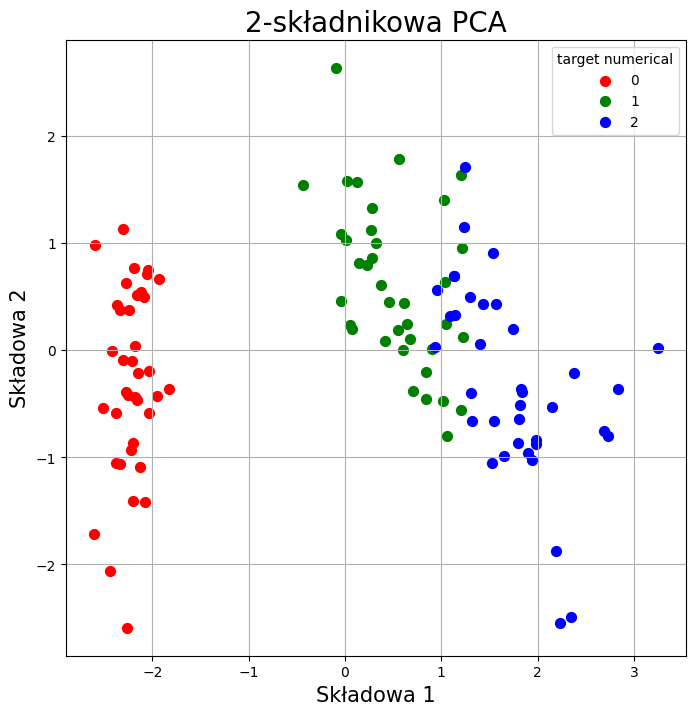

In [9]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Składowa 1', fontsize = 15)
ax.set_ylabel('Składowa 2', fontsize = 15)
ax.set_title('2-składnikowa PCA', fontsize = 20)
targets = [0,1,2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = pca_df['target numerical'] == target
    ax.scatter(pca_df.loc[indicesToKeep, 'PC1']
               , pca_df.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets, title='target numerical')
ax.grid()

Można też użyć funkcji [`scatterplot` z biblioteki seaborn](https://seaborn.pydata.org/generated/seaborn.scatterplot.html#seaborn-scatterplot) - jest to bardzo pomocna biblioteka do wizualizacji DataFrame'ów przy użyciu krótszego kodu (ale oparta na matplotlibie, więc jego też warto znać).

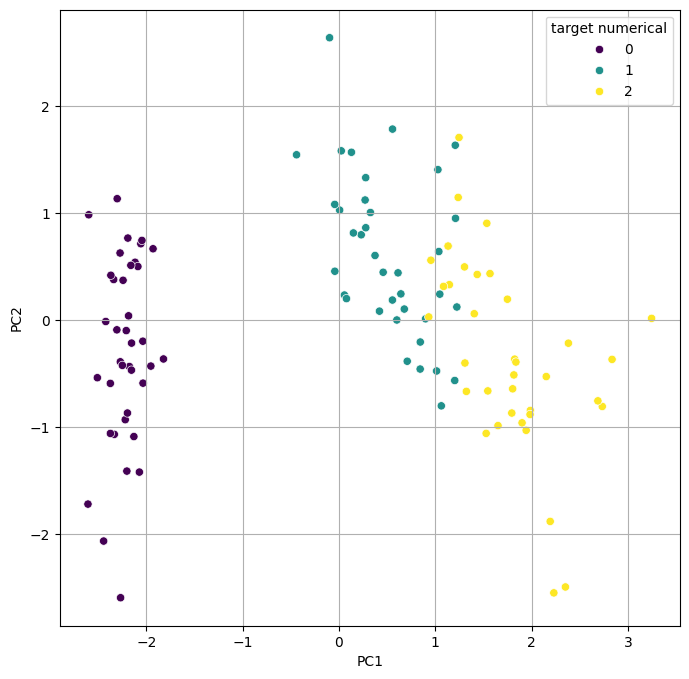

In [59]:
import seaborn as sns

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='target numerical',
                ax=ax, palette='viridis') # podajemy ramkę z danymi, a nastepnie nazwy kolumn, które mają być na osiach x, y oraz kolumnę, która ma być użyta do kolorowania punktów (hue)
ax.grid()

Co sądzisz o powyższym wykresie? Czy dwie składowe wystarczają do poprawnego odróżnienia od siebie wszystkich trzech gatunków?

Możemy też sprawdzić, jaki procent zmienności jest wyjaśniany przez poszczególne składowe. To nam pomoże w podjęciu decyzji, ile składowych jest potrzebnych.

Zasada jest taka, że pierwsza składowa zawsze wyjaśnia największą część zmienności, a każda kolejna coraz mniejszą.

In [81]:
pca.explained_variance_ratio_

array([0.73911238, 0.22125712])

Z powyższych wartości wynika, że pierwsza składowa wyjaśnia ok. 74% zmienności, a druga ok. 22%. Pozostałe ok. 4% są wyjaśniane przez dalsze składowe.

Jeżeli stosujemy PCA do redukcji wymiarowości, to zawsze będziemy musieli odrzucić część składowych i nowe parametry opisujące obiekty (bazujące na wybranych składowych głównych) nigdy nie będą wyjaśniać całej zmienności zawartej w oryginalnym zbiorze danych.